In [1]:
import numpy as np
import cvxpy as cp
import sympy as sym
import pandas as pd
import tensorflow as tf
import torch 
from cvxpylayers.tensorflow import CvxpyLayer
# from sklearn import preprocessing
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

%run Functs.ipynb
%run GSSP.ipynb
%run PGMB.ipynb
%run Proximal.ipynb

### Compare Portfolios

**Aproaches:**<br>
**(1)** Equaly weighed portfolio: $${w}_{opt} = {w}_{ew} = \frac{1}{N}1$$

**(2)** Least squares problem(solved using cvxpy): $${w}_{opt} = \textrm{arg min} \lVert Xw - r^{*} 1 \lVert^{2}_{2}$$

**(3)** Lasso problem(proximal gradient descent): $${w}_{opt} = \textrm{arg min} \lVert Xw - r^{*} 1 \lVert^{2}_{2} +\lambda\lVert w \lVert_{1}$$
Solved by implementing gradient descent and soft thresholding the result by $\lambda\tau$ after each step:
                                    $$prox_{L1}(\beta) = S_{\lambda\tau}(\beta) $$
                                    with $\beta$ being the result of a gradient descent step of the least squares equation.

**(4-5)** Sparse-Convex approach. Find a k-sparse portfolio wk that
replicates performance of the (very non-sparse) equally weighted
portfolio $w_{ew}$ . Amounts to solving: $${w}_{opt} = \textrm{arg min} \lVert Xw - Xw_{ew} \lVert^{2}_{2}$$
Solved using Gradient Descent (solutions 3 and 4 are for k=5 and k=10 respectively).
<br>
<br>
**Constraints of every problem:** $$\quad w^{\top}\hat{\mu}=r^{*} $$
                              $$w^{\top}=1 $$
                              $$w_{i}\geq{0} $$


In [2]:
def loss_fn(X, Y, w):
    return cp.norm2(X @ w - Y)**2

def regularizer(w):
    return cp.norm1(w)

def objective_fn(X, Y, w, lambd):
    return loss_fn(X, Y, w) + lambd * regularizer(w)

In [3]:
# data = pd.read_csv(r'Data.csv', header=None)
# data.columns=np.arange(data.shape[1])
# data.shape

data = pd.read_csv(r'48_Industry_Portfolios_Daily.csv')
data.columns=np.arange(data.shape[1])
data_size = 600
data = data.iloc[-data_size:,1:]
data.shape

(600, 48)

In [4]:
data_size = data.shape[0]
past_window = 60
future_window = 12


RR = data/100
numportfolios = 8
returns = np.zeros((numportfolios,data_size-past_window))
rho = 0.5/12
y = rho*np.ones(past_window)
num_of_assets = 48
portfolios = np.zeros((numportfolios,num_of_assets))

In [5]:
portfolios[0] = np.ones(num_of_assets)/num_of_assets
for i in range (past_window,data_size,future_window):
#equally weighted portfolio
    returns[0][i-past_window:i-past_window+future_window] = np.dot(RR[i:i+future_window],portfolios[0])

In [6]:
%%time
for i in range (past_window, data_size,future_window):
#     print((i/future_window) - 4,"of",((data_size-past_window)//future_window))    

    Phi = RR[i-past_window:i]
    
#CVX least squares   
    w = cp.Variable(num_of_assets, nonneg=True)
    least_squares_cost = cp.sum_squares(Phi.to_numpy()[0] @ w - y)
    least_squares_prob = cp.Problem(cp.Minimize(
                                    objective_fn(Phi.to_numpy()[0], y, w, 0)),
                                    [cp.sum(w) == 1,])
    least_squares_prob.solve(solver="ECOS")
    portfolios[1] = (w.value)
    returns[1][i-past_window:i-past_window+future_window] = np.dot(RR[i:i+future_window],portfolios[1])


Wall time: 979 ms


In [7]:
%%time
for i in range (past_window, data_size,future_window):
    print((i/future_window) - 4,"of",((data_size-past_window)//future_window))    
    Phi = RR[i-past_window:i]
#Lasso  
    prox_y = rho*np.ones((past_window,1))
    x0=np.ones((num_of_assets,1))/num_of_assets    
    w = proximal_gradient_descent(x0,0.1,1,0.25,0.001, 100, Phi, prox_y)

    portfolios[2] = w.T
#     print(portfolios[2])
#     print(np.sum(portfolios[2]))
    returns[2][i-past_window:i-past_window+future_window] = np.dot(RR[i:i+future_window],portfolios[2])
#this model takes some time

1.0 of 45
2.0 of 45
3.0 of 45
4.0 of 45
5.0 of 45
6.0 of 45
7.0 of 45
8.0 of 45
9.0 of 45
10.0 of 45
11.0 of 45
12.0 of 45
13.0 of 45
14.0 of 45
15.0 of 45
16.0 of 45
17.0 of 45
18.0 of 45
19.0 of 45
20.0 of 45
21.0 of 45
22.0 of 45
23.0 of 45
24.0 of 45
25.0 of 45
26.0 of 45
27.0 of 45
28.0 of 45
29.0 of 45
30.0 of 45
31.0 of 45
32.0 of 45
33.0 of 45
34.0 of 45
35.0 of 45
36.0 of 45
37.0 of 45
38.0 of 45
39.0 of 45
40.0 of 45
41.0 of 45
42.0 of 45
43.0 of 45
44.0 of 45
45.0 of 45
Wall time: 2min 36s


In [18]:
%%time
for i in range (past_window, data_size,future_window):
    Phi = RR[i-past_window:i]
#sparse-convex
    w_ew = np.dot(Phi,np.ones((num_of_assets,1)))/num_of_assets
    # k=5
    x0=np.zeros((num_of_assets,1))
    x0[0] = 1/2
    x0[1] = 1/2
    w = PGMB(x0,0.1,1,0.25,0.001, 200, Phi, w_ew, 5)
    portfolios[3] = w.T
    
    # k=10
    x0=np.zeros((num_of_assets,1))
    x0[0] = 1/2
    x0[1] = 1/2
    w = PGMB(x0,0.1,1,0.25,0.001, 200, Phi, w_ew, 10)
#     print(w)
    portfolios[4] = w.T
    returns[3][i-past_window:i-past_window+future_window] = np.dot(RR[i:i+future_window],portfolios[3])
    returns[4][i-past_window:i-past_window+future_window] = np.dot(RR[i:i+future_window],portfolios[4])

Wall time: 9.73 s


In [9]:
%%time
#CVXPY-layers Least Squares
for i in range (past_window, data_size,future_window):
    Phi = RR[i-past_window:i]

    w = cp.Variable((num_of_assets),nonneg=True)
    constraints = [cp.sum(w) == 1, w>=0]
    ls_prob = cp.Problem(cp.Minimize(
                                    objective_fn(Phi.to_numpy()[0], y, w, 0)),
                                    [cp.sum(w) == 1,])
    assert ls_prob.is_dpp()
    cvxpylayer = CvxpyLayer(ls_prob, parameters=[], variables=[w])
    A_tch = torch.randn(past_window, num_of_assets, requires_grad=True)
    b_tch = torch.randn(past_window, requires_grad=True)
    solution, = cvxpylayer()
    portfolios[5] = solution.numpy()
    #Calculate the returns
    returns[5][i-past_window:i-past_window+future_window] = np.dot(RR[i:i+future_window],portfolios[5])

Wall time: 1.36 s


In [10]:
#ew_replication sparse
for i in range (past_window, data_size,future_window):
#     print(i)
    Phi = RR[i-past_window:i]
    w = cp.Variable((num_of_assets))
    A = cp.Parameter((past_window, num_of_assets))
    A.value = Phi.to_numpy()
    W_EW = cp.Parameter((past_window))
    W_EW.value = np.dot(Phi,np.ones((num_of_assets)))/num_of_assets
    
    cost = cp.sum_squares(A @ w - W_EW) + cp.norm1(w)
    prob = cp.Problem(
                        cp.Minimize(cost),
                        [cp.sum(w) == 1,
                        w >= 0,]
                        )

    assert prob.is_dpp()

    cvxpylayer = CvxpyLayer(prob, parameters=[A,W_EW], variables=[w])
    A_tf = tf.Variable(tf.random.normal((past_window, num_of_assets)))
    b_tf = tf.Variable(tf.random.normal((past_window,)))
    solution, = cvxpylayer(A_tf, b_tf)
    portfolios[6] = solution.numpy()
    #Calculate the returns
    returns[6][i-past_window:i-past_window+future_window] = np.dot(RR[i:i+future_window],portfolios[6])

In [11]:
#Optimization using LSTM predictions

df = pd.read_csv(r'LSTM_Predictions.csv')
df
predictions = df.to_numpy()
predictions

array([[1.20222151, 1.89421535, 2.64356065, ..., 1.64894319, 1.77727616,
        2.38053584],
       [1.21081126, 1.89378655, 2.64868689, ..., 1.65413475, 1.77900314,
        2.37399292],
       [1.22105289, 1.89444196, 2.65892601, ..., 1.66214275, 1.78160405,
        2.36449218],
       ...,
       [1.48023951, 2.26023436, 3.32472873, ..., 2.36965394, 2.61767054,
        2.95708394],
       [1.47867918, 2.25945449, 3.32115889, ..., 2.3665328 , 2.61760831,
        2.95107627],
       [1.47726011, 2.25870943, 3.31788325, ..., 2.36370564, 2.61756158,
        2.94559789]])

In [12]:
return_predictions = np.zeros((predictions.shape[0],predictions.shape[1]))
for stocknum in range(num_of_assets):
    for x in range (len(predictions[:,stocknum])-1):
        return_predictions[x+1,stocknum] = ((predictions[x+1,stocknum]-predictions[x,stocknum])/(predictions[x,stocknum]))
    return_predictions[0,stocknum] = return_predictions[1,stocknum]
return_predictions

array([[ 7.14489341e-03, -2.26371207e-04,  1.93914139e-03, ...,
         3.14841931e-03,  9.71703227e-04, -2.74850769e-03],
       [ 7.14489341e-03, -2.26371207e-04,  1.93914139e-03, ...,
         3.14841931e-03,  9.71703227e-04, -2.74850769e-03],
       [ 8.45848404e-03,  3.46085822e-04,  3.86573602e-03, ...,
         4.84120368e-03,  1.46200319e-03, -4.00200939e-03],
       ...,
       [-1.15938769e-03, -3.60941434e-04, -1.16057974e-03, ...,
        -1.45536234e-03, -2.77787619e-05, -2.25164729e-03],
       [-1.05410670e-03, -3.45038190e-04, -1.07372411e-03, ...,
        -1.31712803e-03, -2.37719943e-05, -2.03162016e-03],
       [-9.59685780e-04, -3.29751302e-04, -9.86292126e-04, ...,
        -1.19464539e-03, -1.78521902e-05, -1.85640140e-03]])

In [13]:
y = rho/5*np.ones(future_window)
Phi = RR[i-past_window:i]

for i in range (0,return_predictions.shape[0],future_window):
    current_window_predictions = return_predictions[i:i+12]
#CVX least squares   
    w = cp.Variable(num_of_assets, nonneg=True)
    least_squares_cost = cp.sum_squares(current_window_predictions[0] @ w - y)
    least_squares_prob = cp.Problem(cp.Minimize(
                                    objective_fn(current_window_predictions[0], y, w, 0)),
                                    [cp.sum(w) == 1,])
    least_squares_prob.solve()
    portfolios[7] = (w.value)
    print(portfolios[7])
    returns[7][i:i+12] = np.dot(RR[i+past_window:i+past_window+future_window],portfolios[7])
returns[7]

[0.01767352 0.00539503 0.00677912 0.0074435  0.00591035 0.00331141
 0.00548866 0.00362235 0.00999062 0.00577191 0.01420124 0.00701906
 0.0055456  0.00147726 0.02638816 0.00853106 0.0081309  0.00645136
 0.0388272  0.00427406 0.00832124 0.0044644  0.04039742 0.00442053
 0.01033844 0.01001366 0.00157967 0.00154732 0.00559155 0.00184599
 0.00475156 0.0465493  0.00384694 0.0074193  0.5753978  0.00521992
 0.00535309 0.00428784 0.00819044 0.00833778 0.00920876 0.00403513
 0.00795407 0.00488135 0.00545557 0.00791666 0.00608153 0.00436036]
[0.01721945 0.02000483 0.01846284 0.01826666 0.01970406 0.02369513
 0.01938319 0.0222044  0.01876168 0.01896818 0.01805117 0.01832079
 0.01914361 0.04661801 0.01818305 0.01795343 0.01887645 0.0190767
 0.01592493 0.02371815 0.01773329 0.02029269 0.01704652 0.02084987
 0.01725396 0.01756487 0.01778456 0.07464623 0.02189591 0.01626248
 0.02126933 0.01663868 0.0232052  0.01852952 0.01701218 0.01879011
 0.01912149 0.02037603 0.01827055 0.01807758 0.01762212 0.0191

[0.02088139 0.02041578 0.02095337 0.020823   0.02065265 0.02062739
 0.02093905 0.01923008 0.02002318 0.02045424 0.0198861  0.02033938
 0.02060468 0.0167927  0.01910368 0.02071475 0.01977941 0.02227152
 0.0207629  0.0158278  0.02050575 0.02013364 0.02017307 0.020038
 0.02082067 0.02095107 0.01967044 0.01513065 0.02077364 0.05251847
 0.02022362 0.02164942 0.02098239 0.02062981 0.02093948 0.02096383
 0.02027241 0.02001032 0.02043498 0.02059954 0.02100919 0.01967985
 0.02012381 0.01999039 0.02042281 0.02037864 0.01981685 0.02007422]
[0.01740903 0.0204583  0.01901277 0.02026733 0.02009239 0.01933877
 0.01891699 0.02298154 0.01966405 0.01858933 0.02155162 0.01901255
 0.01841028 0.03078643 0.02613392 0.01881174 0.02251282 0.01495285
 0.01589381 0.06980841 0.01801303 0.01615484 0.01934328 0.02155835
 0.01661444 0.01911388 0.01705404 0.04043662 0.02336754 0.00532663
 0.02121481 0.01614962 0.01729045 0.01890921 0.01843679 0.01771477
 0.02003656 0.02121533 0.01819251 0.01846741 0.01735336 0.01870

array([ 1.32175732e-03, -2.72089955e-02,  9.33871769e-03,  3.95043121e-03,
        4.00177413e-03, -8.89150921e-03, -9.78062443e-03,  1.51136102e-02,
       -1.15061087e-02, -1.94146645e-02,  7.17222835e-03, -2.83780369e-03,
       -8.28382378e-03, -1.90080697e-03, -1.53255260e-02,  4.31023052e-03,
        2.42040692e-02, -6.22453297e-03, -3.94821773e-03,  8.45544855e-03,
        7.62787675e-03,  9.69333788e-04, -3.95685445e-03,  1.23332612e-02,
       -7.92769405e-03,  2.68873254e-04,  9.70817006e-03,  2.23660308e-03,
        8.51420733e-03, -4.92966940e-03, -8.81071242e-03, -5.07101698e-03,
        8.04386040e-04,  1.24462039e-02,  1.41587623e-02,  3.36149226e-03,
       -4.09734671e-03,  5.79421511e-03,  2.87769306e-03, -5.95528398e-03,
       -3.60867176e-03,  3.28312059e-03, -2.70221412e-03,  5.79693558e-03,
       -2.84915137e-03,  1.45572940e-03, -1.03272821e-02, -1.09136139e-03,
       -9.26003259e-04, -4.14151594e-03,  5.41177108e-03,  1.05141483e-02,
       -1.15154249e-02,  

In [14]:
# Calculate the cumulative returns
CumulativeReturns = np.zeros(returns.shape)
for j in range(numportfolios):
    CumulativeReturns[j] = np.cumsum(returns[j])
CumulativeReturns.shape

(8, 540)

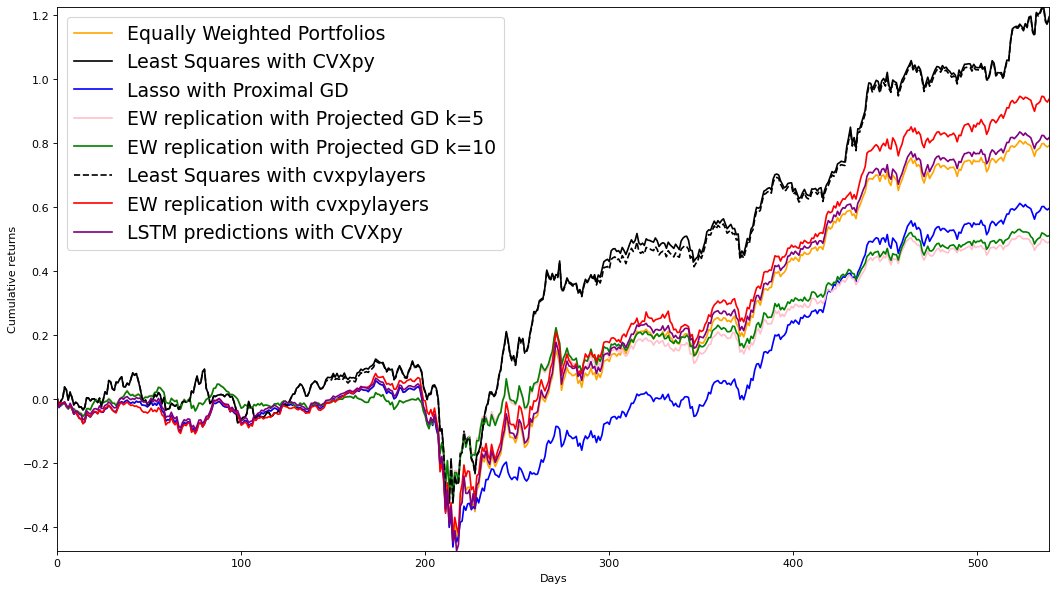

In [15]:
figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(CumulativeReturns[0],color='orange')
plt.plot(CumulativeReturns[1],color='black')
plt.plot(CumulativeReturns[2],color='blue')
plt.plot(CumulativeReturns[3],color='pink')
plt.plot(CumulativeReturns[4],color='green')
plt.plot(CumulativeReturns[5],color='black', linestyle='dashed')
plt.plot(CumulativeReturns[6],color='red')
plt.plot(CumulativeReturns[7],color='purple')


plt.margins(0)

legend = ['Equally Weighted Portfolios',
          'Least Squares with CVXpy',
          'Lasso with Proximal GD',
          'EW replication with Projected GD k=5',
          'EW replication with Projected GD k=10',
          'Least Squares with cvxpylayers',
          'EW replication with cvxpylayers',
          'LSTM predictions with CVXpy']
plt.legend(legend ,loc = "upper left",prop={'size': 17})
plt.xlabel('Days')
plt.ylabel('Cumulative returns')

plt.show()

### Final Portfolio Values


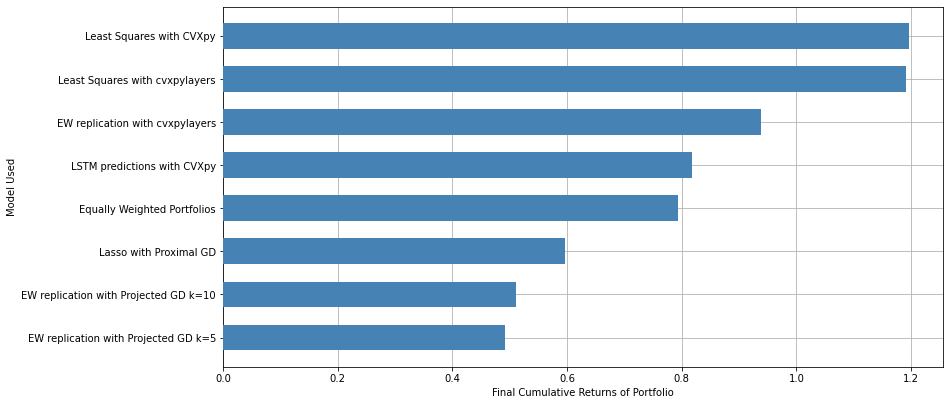

In [16]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor("w")

ax = fig.add_axes([0,0,1,1])
Final_Returns = CumulativeReturns[:,-1]

Sorted_Final_Returns = np.zeros(numportfolios)
Sorted_Legend = np.empty(numportfolios, dtype="S50")
Sorted_Final_Returns_Indexes = np.argsort(Final_Returns)

for x in range(numportfolios):
    Sorted_Final_Returns[x] = Final_Returns[Sorted_Final_Returns_Indexes[x]]
    Sorted_Legend[x] = legend[Sorted_Final_Returns_Indexes[x]]

ax.barh(Sorted_Legend,Sorted_Final_Returns, align='center',height=0.6, color='steelblue', zorder=3)
ax.grid(zorder=0)

plt.xlabel('Final Cumulative Returns of Portfolio')
plt.ylabel('Model Used')
plt.show()

###  Average Returns

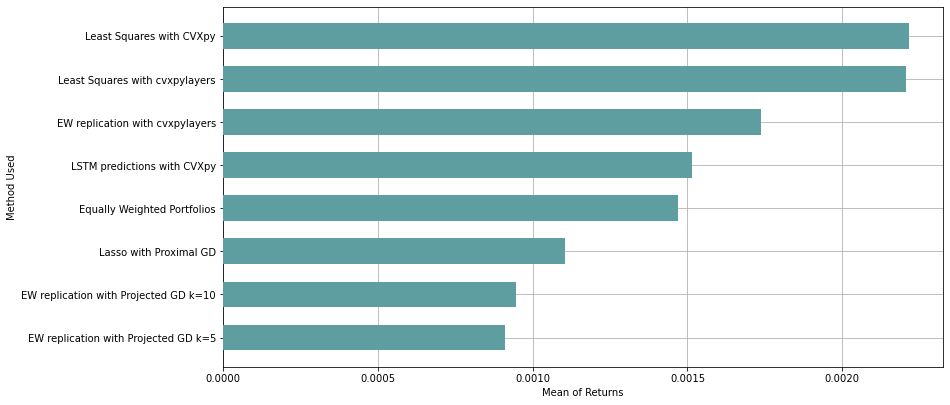

In [17]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor("w")

ax = fig.add_axes([0,0,1,1])
Average_Returns = np.zeros(numportfolios)
for x in range(len(Average_Returns)):
    Average_Returns[x] = np.mean(returns[x])

Sorted_Average_Returns = np.zeros(numportfolios)
Sorted_Legend = np.empty(numportfolios, dtype="S50")
Sorted_Average_Returns_Indexes = np.argsort(Average_Returns)

for x in range(len(Average_Returns)):
    Sorted_Average_Returns[x] = Average_Returns[Sorted_Average_Returns_Indexes[x]]
    Sorted_Legend[x] = legend[Sorted_Average_Returns_Indexes[x]]

ax.barh(Sorted_Legend,Sorted_Average_Returns, align='center',height=0.6, color='cadetblue', zorder=3)
ax.grid(zorder=0)

plt.xlabel('Mean of Returns')
plt.ylabel('Method Used')
plt.show()